In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

## [Click this link](https://github.com/aangelopoulos/conformal-prediction/blob/main/notebooks/imagenet-raps.ipynb) for a version of APS with much-improved practical performance.

In [2]:
data = np.load("data/imagenet/imagenet-resnet152.npz")
example_paths = os.listdir("data/imagenet/examples")
smx = data["smx"]
labels = data["labels"].astype(int)

In [3]:
# Problem setup
n = 1000  # number of calibration points
alpha = 0.1  # 1-alpha is the desired coverage
randomized = True
no_zero_size_sets = True

In [4]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (smx.shape[0] - n)) > 0
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx, :], smx[~idx, :]
cal_labels, val_labels = labels[idx], labels[~idx]

### Conformal prediction happens here

In [5]:
# Get scores. calib_X.shape[0] == calib_Y.shape[0] == n
cal_pi = cal_smx.argsort(1)[:, ::-1]
cal_srt = np.take_along_axis(cal_smx, cal_pi, axis=1).cumsum(axis=1)
cal_softmax_correct_class = np.take_along_axis(cal_srt, cal_pi.argsort(axis=1), axis=1)[
    range(n), cal_labels
]
if not randomized:
  cal_scores = cal_softmax_correct_class
else:
  cumsum_index = np.where(cal_srt == cal_softmax_correct_class[:,None])[1]
  high = cal_softmax_correct_class
  low = np.zeros_like(high)
  low[cumsum_index != 0] = cal_srt[np.where(cumsum_index != 0)[0], cumsum_index[cumsum_index != 0]-1]
  cal_scores = np.random.uniform(low=low, high=high)

In [6]:
# Get the score quantile
qhat = np.quantile(
    cal_scores, np.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher"
)
# Deploy (output=list of length n, each element is tensor of classes)
val_pi = val_smx.argsort(1)[:, ::-1]
val_srt = np.take_along_axis(val_smx, val_pi, axis=1).cumsum(axis=1)
if not randomized:
  prediction_sets = np.take_along_axis(val_srt <= qhat, val_pi.argsort(axis=1), axis=1)
else:
  n_val = val_srt.shape[0]
  cumsum_index = np.sum(val_srt <= qhat, axis=1)
  high = val_srt[np.arange(n_val), cumsum_index]
  low = np.zeros_like(high)
  low[cumsum_index > 0] = val_srt[np.arange(n_val), cumsum_index-1][cumsum_index > 0]
  prob = (qhat - low)/(high - low)
  rv = np.random.binomial(1,prob,size=(n_val))
  randomized_threshold = low
  randomized_threshold[rv == 1] = high[rv == 1]
  if no_zero_size_sets:
    randomized_threshold = np.maximum(randomized_threshold, val_srt[:,0])
  prediction_sets = np.take_along_axis(val_srt <= randomized_threshold[:,None], val_pi.argsort(axis=1), axis=1)

In [7]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[
    np.arange(prediction_sets.shape[0]), val_labels
].mean()
print(f"The empirical coverage is: {empirical_coverage}")

The empirical coverage is: 0.9279183673469388


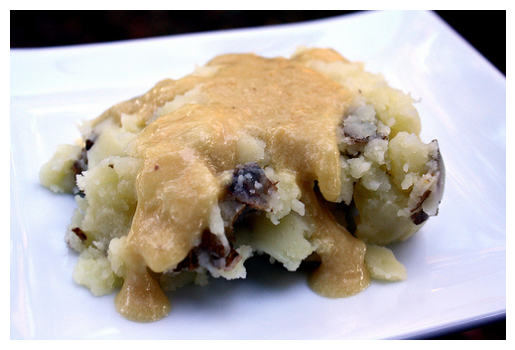

The prediction set is: ['pot pie']


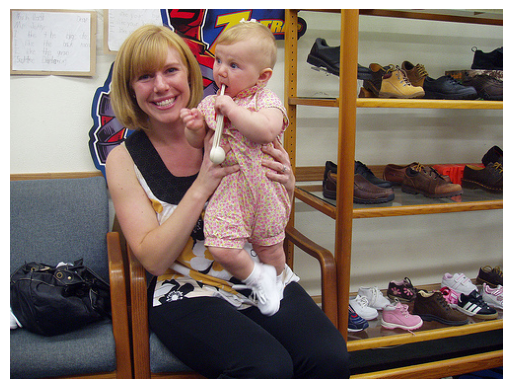

The prediction set is: ['shoe store']


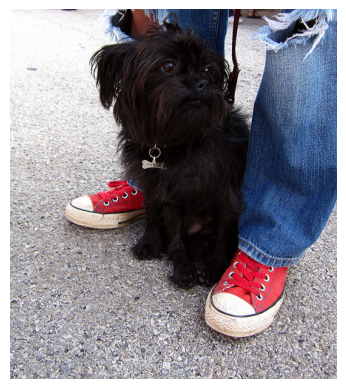

The prediction set is: ['Affenpinscher']


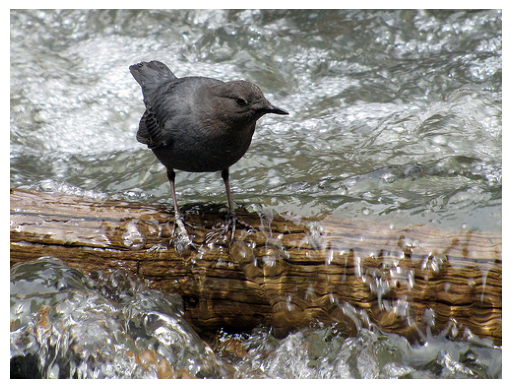

The prediction set is: ['American dipper']


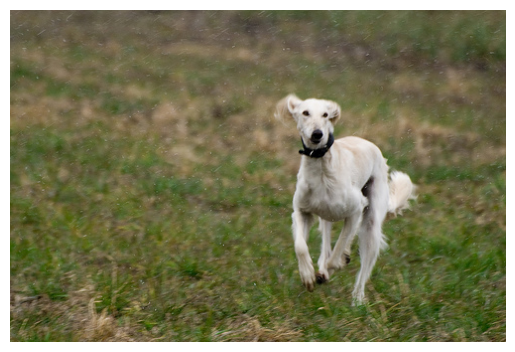

The prediction set is: ['Whippet', 'Saluki']


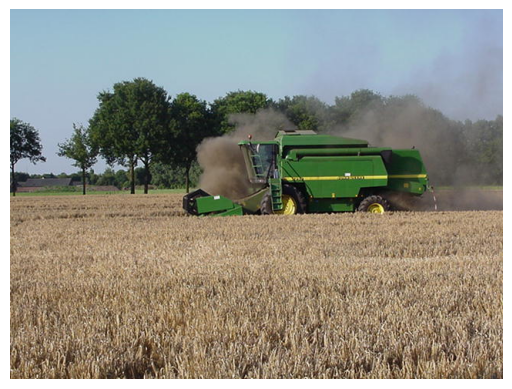

The prediction set is: ['harvester']


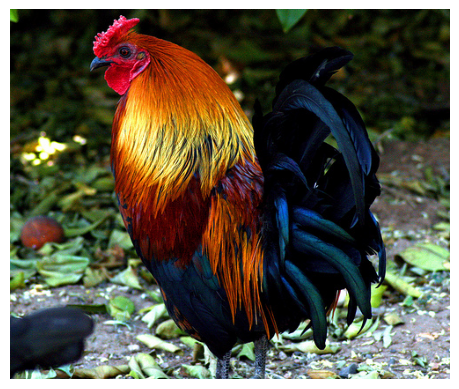

The prediction set is: ['cock']


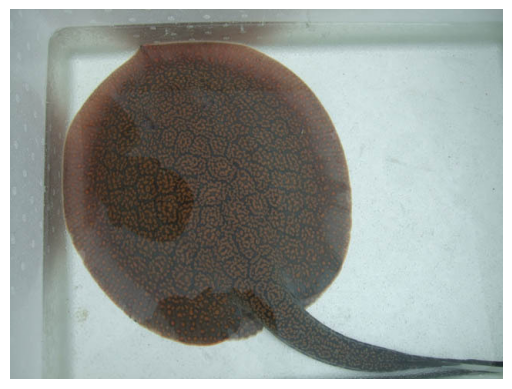

The prediction set is: ['electric ray']


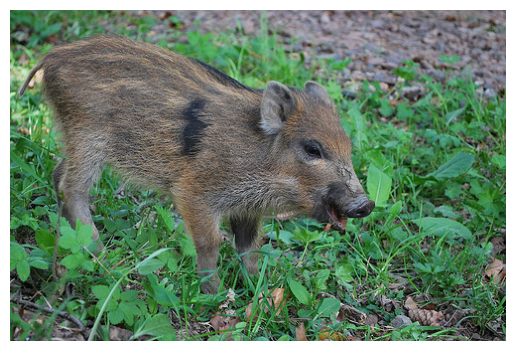

The prediction set is: ['pig', 'wild boar']


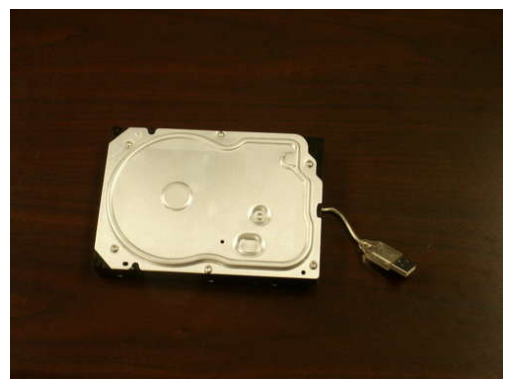

The prediction set is: ['hard disk drive']


In [8]:
# Show some examples
with open("data/imagenet/human_readable_labels.json") as f:
    label_strings = np.array(json.load(f))

example_paths = os.listdir("data/imagenet/examples")
for i in range(10):
    rand_path = np.random.choice(example_paths)
    img = imread("data/imagenet/examples/" + rand_path)
    img_index = int(rand_path.split(".")[0])
    img_pi = smx[img_index].argsort()[::-1]
    img_srt = np.take_along_axis(smx[img_index], img_pi, axis=0).cumsum()
    if not randomized:
      prediction_set = np.take_along_axis(img_srt <= qhat, img_pi.argsort(), axis=0)
    else:
      cumsum_index = np.sum(img_srt <= qhat)
      high = img_srt[cumsum_index]
      low = 0 if cumsum_index == 0 else img_srt[cumsum_index - 1]
      prob = (qhat - low)/(high - low)
      rv = np.random.binomial(1,prob)
      randomized_threshold = low if rv == 0 else high
      if no_zero_size_sets:
        randomized_threshold = np.maximum(randomized_threshold, img_srt[0])
      prediction_set = np.take_along_axis(img_srt <= randomized_threshold, img_pi.argsort(), axis=0)
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print(f"The prediction set is: {list(label_strings[prediction_set])}")

This method was first introduced in https://arxiv.org/abs/2006.02544 and studied further for image classifiers in https://arxiv.org/abs/2009.14193.